In [143]:
#Importing packages
from selenium import webdriver
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain
nltk.download('punkt')
nltk.download('wordnet')

import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Note for myself 11/5
1. Task C: dataframe
2. bigram + trigram + one word
3. put on text

## Scraper
First of all, don't run it!, it took me hours to scrape all the data (It should not have taken so long but I don't know why).

Secondly, I scraped around 7500 most recent pieces of comment instead of 5000 because the most recent 5000 comments are contributed by 68 users. With 7500 comments, we can get opioins from 130 users, which diversifys our data.

In [144]:
# %%time

# #change directory where you put your chrome driver
# options = webdriver.ChromeOptions()
# options.add_argument('headless')
# driver = webdriver.Chrome("chromedriver", options=options)

# all_comments = pd.DataFrame(columns = ['Date','user_id', 'comments']) 

# x = 284
# pages_scraped = 434
# driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}'.format(x))

# while x <= pages_scraped:
#     print("page",x)
    
#     if x > 1:
#         driver.find_element_by_link_text("{}".format(x)).click()
#         driver.implicitly_wait(3)
    
#     ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
#     comment_ids = []
#     for i in ids:
#         comment_ids.append(i.get_attribute('id'))

#     for d in comment_ids:

#         #Extract dates from for each user on a page
#         user_date = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
#         date = user_date.get_attribute('title')

#         #Extract user ids from each user on a page
#         userid_element = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
#         userid = userid_element.text

#         #Extract Message for each user on a page
#         if driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/p'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/p')[0]
#             comment = user_message.text
#         elif driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/ul/li'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/ul/li')[0]
#             comment = user_message.text
#         elif driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]')[0]
#             comment = user_message.text
#         else: 
#             comment = None
        
#         #Adding date, userid and comment for each user in a dataframe    
#         all_comments.loc[len(all_comments)] = [date,userid,comment]
        
#     x += 1

In [145]:
# all_comments.to_csv("7500_comments_edmunds.csv", sep="\t")

## Load the data
We have 7506 rows of comments from 2012-8-10 to 2019-8-21, comtibuted by 130 users.

In [146]:
df = pd.read_csv("7500_comments_edmunds.csv", sep="\t", parse_dates=['Date'])
df = df[['Date', 'user_id', 'comments']]
df = df.dropna()

### Preprocess comments

In [147]:
%%time
# tokenization
df['tokens'] = df['comments'].map(nltk.word_tokenize)
df['bigrams'] = df['tokens'].map(lambda x: list(nltk.bigrams(x)))
df['trigrams'] = df['tokens'].map(lambda x: list(nltk.trigrams(x)))
df['tokens'] = df['tokens'].map(lambda x: set(x))

# lemmatization
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 20.5 s


## Replace model to brand

In [148]:
%%time
models = pd.read_csv("models (5).csv", header = None)
models.columns = ['brand', 'model']

## clean brand list
models.loc[(models['brand'] == 'mercedes'),'brand'] = 'mercedes-benz'
models.loc[(models['brand'] == 'mercedes benz'),'brand'] = 'mercedes-benz'
models.loc[(models['brand'] == 'kia.'),'brand'] = 'kia'
models.loc[(models['brand'] == 'kia,'),'brand'] = 'kia'
models.loc[(models['brand'] == 'hyndai kia'),'brand'] = 'kia'
models.loc[(models['brand'] == 'hyundai,'),'brand'] = 'hyundai'
models.loc[(models['brand'] == 'hyundai.'),'brand'] = 'hyundai'
models.loc[(models['brand'] == 'nissan.'),'brand'] = 'nissan'
models.loc[(models['brand'] == 'toyata'),'brand'] = 'toyota'
models.loc[(models['brand'] == 'volkwagen'),'brand'] = 'volkswagen'

def model_to_brand(word):
    if word.lower() in models['model'].values:
        brand = models[models['model'] == word].iloc[-1,0]
#         print('replace ' + word + ' to ' + brand)
        return(brand)
    else:
        return(word)

df['processed'] = df['processed'].map(lambda x: [model_to_brand(word) for word in x])

Wall time: 23.2 s


## Task A: get top 10 list
Filter brands from word_frequency

In [149]:
all_words = pd.Series(chain(*list(df['processed'])))
word_frequency = all_words.value_counts()

brand_list = models['brand'].drop_duplicates().values
no_use = ['car', 'sedan', 'seat', 'problem']
brand_list = [ x for x in brand_list if x not in no_use]

tmp = pd.DataFrame(word_frequency)
tmp['word'] = word_frequency.index
mask = tmp['word'].isin(brand_list)
brand_frequency = word_frequency[mask]
top10_brands = brand_frequency.head(10)
top10_brands

bmw              2551
audi             1911
acura            1134
honda            1000
infiniti          662
volkswagen        539
toyota            488
mercedes-benz     411
hyundai           396
ford              376
dtype: int64

## Task A: calculate lift ratios for associations between the brands

In [150]:
def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['processed'].map(lambda x: b in x))
    if N_a*N_b == 0:
        return(None)
    else:
        return(N*N_ab/(N_a*N_b))

In [151]:
lift_brands = pd.DataFrame(top10_brands.index.values, columns=['brand'])
for make in top10_brands.index.values:
    lift_brands[make] = lift_brands['brand'].map(lambda x: lift(x, make))
lift_brands = lift_brands.set_index('brand')
lift_brands

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,mercedes-benz,hyundai,ford
brand,,,,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.179733,1.380993,2.622126,1.247200,1.406985
audi,1.786978,6.082658,2.173920,1.583850,2.593196,2.580048,1.508753,3.480728,1.803823,1.224836
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.392939,1.553917,2.617041,1.531524,1.121724
honda,1.098865,1.583850,3.260322,10.396122,1.409297,2.138020,3.202983,1.737595,1.828284,2.022454
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.250994,1.617116,3.467322,2.034009,1.258239
volkswagen,1.179733,2.580048,1.392939,2.138020,1.250994,19.295630,2.367871,1.639855,2.195710,2.831782
toyota,1.380993,1.508753,1.553917,3.202983,1.617116,2.367871,19.597911,1.998654,3.041055,2.742370
mercedes-benz,2.622126,3.480728,2.617041,1.737595,3.467322,1.639855,1.998654,21.263456,2.126346,2.177146
hyundai,1.247200,1.803823,1.531524,1.828284,2.034009,2.195710,3.041055,2.126346,25.882759,2.031752


In [152]:
inverse_lift_brands = lift_brands.apply(lambda x: 1/x)
inverse_lift_brands

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,mercedes-benz,hyundai,ford
brand,,,,,,,,,,
bmw,0.257128,0.559604,0.754420,0.910030,0.527734,0.847650,0.724117,0.381370,0.801796,0.710740
audi,0.559604,0.164402,0.459998,0.631373,0.385625,0.387590,0.662799,0.287296,0.554378,0.816436
acura,0.754420,0.459998,0.112577,0.306718,0.303182,0.717907,0.643535,0.382111,0.652944,0.891485
honda,0.910030,0.631373,0.306718,0.096190,0.709573,0.467722,0.312209,0.575508,0.546961,0.494449
infiniti,0.527734,0.385625,0.303182,0.709573,0.067812,0.799365,0.618385,0.288407,0.491640,0.794762
volkswagen,0.847650,0.387590,0.717907,0.467722,0.799365,0.051825,0.422320,0.609810,0.455434,0.353135
toyota,0.724117,0.662799,0.643535,0.312209,0.618385,0.422320,0.051026,0.500337,0.328833,0.364648
mercedes-benz,0.381370,0.287296,0.382111,0.575508,0.288407,0.609810,0.500337,0.047029,0.470290,0.459317
hyundai,0.801796,0.554378,0.652944,0.546961,0.491640,0.455434,0.328833,0.470290,0.038636,0.492186


## MDS plot

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


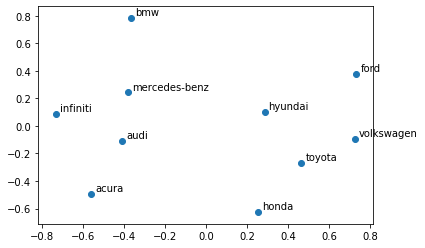

In [153]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, random_state=4)
mds = embedding.fit_transform(inverse_lift_brands)
mds_output = pd.DataFrame(mds, index=inverse_lift_brands.index.values, columns=['x', 'y'])

fig, ax = plt.subplots()
ax.scatter(mds_output['x'], mds_output['y'])
for brand in inverse_lift_brands.index.values:
    ax.text(mds_output.loc[brand, 'x']+0.02, mds_output.loc[brand, 'y']+0.02, brand)

## Task B
**What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)?**

#### (1) Volkswagen: a suspicious luxury brand
Noticing that Volkswagen has a strong accociation with Audi looking at lift, we firstly hypothesized that volkswagen may have been percieved as a luxury brand in recent years. However, with further examined, we found that Volkswagen is not strongly associated with the other mentioned luxury brands and is much more associated with the non-luxury Japanese and American brands. This can be seen through the MDS plot, Volkswagen is much more associated with Ford, Toyota, Honda, and Hyundai than the luxury brands. Through researching these two brands, Audi cars are manufactured under the Volkswagen group, that is most likely why they are associated since many of the low end Audis have the same basic parts and consumers are comparing them. 

#### (2) Mercedes-bendz: the middle man 
Mercedes-bends, looking at the MDS plot is definintely apart of the luxury brand cluster. Mercedes-bends also has high lift values with the other luxury brands, but it also has pretty high lift values with non-luxury brands hyundai (2.126346) and Ford (2.177146). This might have been caused by the non-luxury brands users wanting to upgrade to a luxury brand car and Mercedes-bendz is the brand they are considering the most. 

## Task C
Here we need to re-do the attribute_dict. I will produce a big table of brands and attributes.

Professor mentioned two checking criteria before replacing words to attributes. 

(1) lifts between words of attributes

(2) lifts distribution between brands and words

Will walk through this in next meeting

He mentioned we can just look at top 200 to 300 words. Here I'll look at 300.

In [154]:
# Initial attribute_dict version_1

attribute_dict = { 
    'performance': ['drive', 'engine', 'driving', 'performance', 'power', 'speed'],
    
    'fuel_efficiency': ['mile', 'oil' , 'mpg', 'gas'],
    
    'look': ['look', 'pretty', 'looking', 'wheel', 'tire', 'sport'],
    
    'luxury': ['luxury', 'premium'],
    
    'reliability': ['issue', 'problem'],
    
    'price': ['price', 'cost', 'money', 'sale', 'msrp', 'expensive'],
        
    'size': ['size', 'sedan', 'big', 'little', 'small', 'size'],

    'interior': ['seat', 'interior', 'steering', 'leather']}

In [155]:
n_b = 5 # top n brands I want to look at

for attribute in attribute_dict:
    tolook = list(top10_brands[:n_b].index.values)
    tolook = tolook + attribute_dict[attribute]

    lift_df = pd.DataFrame(tolook, columns=['to_check'])
    for make in tolook:
        lift_df[make] = lift_df['to_check'].map(lambda x: lift(x, make))
    lift_df = lift_df.set_index('to_check')
    display(lift_df)

,bmw,audi,acura,honda,infiniti,drive,engine,driving,performance,power,speed
to_check,,,,,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.542857,1.609863,1.786208,1.698513,1.596360,1.073341
audi,1.786978,6.082658,2.173920,1.583850,2.593196,1.881686,1.583395,2.080388,2.110310,1.910256,2.005751
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.478952,1.415189,1.750527,1.685927,1.688474,1.751098
honda,1.098865,1.583850,3.260322,10.396122,1.409297,1.912545,1.493611,1.608520,1.506377,1.489252,1.900366
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.803536,1.552270,2.065479,1.865892,1.421845,0.951391
drive,1.542857,1.881686,1.478952,1.912545,1.803536,7.714286,1.580167,2.939972,2.030904,2.103896,2.405530
engine,1.609863,1.583395,1.415189,1.493611,1.552270,1.580167,10.677098,1.773720,2.309740,3.059003,3.061534
driving,1.786208,2.080388,1.750527,1.608520,2.065479,2.939972,1.773720,12.224756,2.270312,2.357391,3.373857
performance,1.698513,2.110310,1.685927,1.506377,1.865892,2.030904,2.309740,2.270312,15.318367,2.827357,2.635418


,bmw,audi,acura,honda,infiniti,mile,oil,mpg,gas
to_check,,,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.172909,1.460404,1.372630,1.265359
audi,1.786978,6.082658,2.173920,1.583850,2.593196,1.562357,1.117223,1.155980,1.396974
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.550972,1.595286,1.728335,1.402554
honda,1.098865,1.583850,3.260322,10.396122,1.409297,1.800194,1.400294,1.787568,2.238399
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.212921,1.444561,1.067624,1.128923
mile,1.172909,1.562357,1.550972,1.800194,1.212921,10.831169,3.978797,2.401481,2.953955
oil,1.460404,1.117223,1.595286,1.400294,1.444561,3.978797,30.636735,0.693139,2.198809
mpg,1.372630,1.155980,1.728335,1.787568,1.067624,2.401481,0.693139,33.963801,7.312780
gas,1.265359,1.396974,1.402554,2.238399,1.128923,2.953955,2.198809,7.312780,35.913876


,bmw,audi,acura,honda,infiniti,look,pretty,looking,wheel,tire,sport
to_check,,,,,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.365429,1.483478,1.555648,1.503793,1.233406,2.080521
audi,1.786978,6.082658,2.173920,1.583850,2.593196,1.715810,1.868693,2.053715,2.238418,1.616249,1.938538
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.774417,1.941404,1.738362,1.895006,1.395875,1.386590
honda,1.098865,1.583850,3.260322,10.396122,1.409297,1.611021,2.014918,1.565008,1.857440,1.544567,1.605905
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.696033,1.733101,1.966208,1.808912,1.348257,1.894274
look,1.365429,1.715810,1.774417,1.611021,1.696033,9.087167,1.836170,2.599125,2.641337,1.531837,1.714002
pretty,1.483478,1.868693,1.941404,2.014918,1.733101,1.836170,15.476289,1.763964,2.558746,1.680283,2.088670
looking,1.555648,2.053715,1.738362,1.565008,1.966208,2.599125,1.763964,16.141935,2.410529,1.614194,2.047270
wheel,1.503793,2.238418,1.895006,1.857440,1.808912,2.641337,2.558746,2.410529,20.016000,5.432914,2.831532


,bmw,audi,acura,honda,infiniti,luxury,premium
to_check,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.592687,2.009575
audi,1.786978,6.082658,2.173920,1.583850,2.593196,2.172378,2.662318
acura,1.325522,2.173920,8.882840,3.260322,3.298343,2.157261,2.213960
honda,1.098865,1.583850,3.260322,10.396122,1.409297,2.153482,2.306738
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,2.317317,2.285941
luxury,1.592687,2.172378,2.157261,2.153482,2.317317,17.871429,3.530829
premium,2.009575,2.662318,2.213960,2.306738,2.285941,3.530829,22.814590


,bmw,audi,acura,honda,infiniti,issue,problem
to_check,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.537933,1.486727
audi,1.786978,6.082658,2.173920,1.583850,2.593196,2.002366,1.740102
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.416105,1.416757
honda,1.098865,1.583850,3.260322,10.396122,1.409297,1.528208,1.552838
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.343372,1.455990
issue,1.537933,2.002366,1.416105,1.528208,1.343372,15.540373,3.344131
problem,1.486727,1.740102,1.416757,1.552838,1.455990,3.344131,19.002532


,bmw,audi,acura,honda,infiniti,price,cost,money,sale,msrp,expensive
to_check,,,,,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.751929,1.519187,1.427651,1.705563,1.974023,1.649471
audi,1.786978,6.082658,2.173920,1.583850,2.593196,1.769616,1.960232,2.040385,2.004898,2.280997,2.343125
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.546855,1.630834,1.742836,2.481240,1.783297,1.797306
honda,1.098865,1.583850,3.260322,10.396122,1.409297,1.647769,1.766529,2.061678,1.597170,1.850825,1.860784
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.860619,1.900924,2.177762,2.553874,2.066753,2.180425
price,1.751929,1.769616,1.546855,1.647769,1.860619,7.826903,2.476481,2.229181,2.251874,3.705920,2.405935
cost,1.519187,1.960232,1.630834,1.766529,1.900924,2.476481,14.660156,3.247503,1.801807,3.442915,4.107125
money,1.427651,2.040385,1.742836,2.061678,2.177762,2.229181,3.247503,15.835443,2.078955,3.059120,2.895976
sale,1.705563,2.004898,2.481240,1.597170,2.553874,2.251874,1.801807,2.078955,20.966480,2.541392,2.039541


,bmw,audi,acura,honda,infiniti,size,sedan,big,little,small
to_check,,,,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.702533,1.887125,1.405101,1.411863,1.438240
audi,1.786978,6.082658,2.173920,1.583850,2.593196,2.662794,1.770900,1.779014,1.896597,1.951041
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.715570,1.874017,1.948494,1.998144,1.374326
honda,1.098865,1.583850,3.260322,10.396122,1.409297,1.561649,1.776552,2.123939,1.968085,1.686918
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.329089,2.364428,1.395374,1.642156,1.558127
size,1.702533,2.662794,1.715570,1.561649,1.329089,32.214592,2.786494,2.978984,2.295917,4.133193
sedan,1.887125,1.770900,1.874017,1.776552,2.364428,2.786494,15.835443,2.247611,1.481266,1.912204
big,1.405101,1.779014,1.948494,2.123939,1.395374,2.978984,2.247611,16.141935,2.408708,2.984735
little,1.411863,1.896597,1.998144,1.968085,1.642156,2.295917,1.481266,2.408708,16.717149,3.280346


,bmw,audi,acura,honda,infiniti,seat,interior,steering,leather
to_check,,,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.781411,1.366447,2.287717,1.684760
audi,1.786978,6.082658,2.173920,1.583850,2.593196,1.862038,2.400184,1.610115,2.413362
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.450260,2.088668,1.698190,2.013923
honda,1.098865,1.583850,3.260322,10.396122,1.409297,1.650178,1.517272,1.872831,1.978209
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.571629,1.992779,1.843320,2.029891
seat,1.781411,1.862038,1.450260,1.650178,1.571629,17.020408,4.508108,5.131152,7.717756
interior,1.366447,2.400184,2.088668,1.517272,1.992779,4.508108,20.286486,3.952882,6.899048
steering,2.287717,1.610115,1.698190,1.872831,1.843320,5.131152,3.952882,27.595588,4.245475
leather,1.684760,2.413362,2.013923,1.978209,2.029891,7.717756,6.899048,4.245475,30.388664


## Analysis on attribute_dict
Based on the matrix above, in each attribute, we will delete:

1. performance: speed
2. fuel_efficiency: oil (because mpg seems have higher lift with other words/ brands)

And to make more sense and more interpretable, I deleted:

1. price 
2. interior
3. size: big, sedan, little (we don't say size is little)

In [156]:
attribute_dict = { 
    'performance': ['drive', 'engine', 'driving', 'performance', 'power'],
    
    'fuel_efficiency': ['mile', 'mpg', 'gas'],
    
    'look': ['look', 'pretty', 'looking', 'wheel', 'tire', 'sport'],
    
    'luxury': ['luxury', 'premium'],
    
    'issue_problem': ['issue', 'problem'],
    
#     'price': ['price', 'cost', 'money', 'sale', 'msrp', 'expensive'],
        
    'size': ['size', 'small']}

## Task C: Find top 5 attributes

In [157]:
def count_attribute(df, attribute_terms):
    return(np.sum(df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1 )))

top_attributes = pd.DataFrame(pd.Series(attribute_dict), columns=['attribute_terms'])
top_attributes['count'] = top_attributes['attribute_terms'].map(lambda x: count_attribute(df, x))

top_attributes = top_attributes.sort_values(by=['count'], ascending=False)
top_attributes

,attribute_terms,count
performance,"[drive, engine, driving, performance, power]",2253
look,"[look, pretty, looking, wheel, tire, sport]",2252
fuel_efficiency,"[mile, mpg, gas]",987
issue_problem,"[issue, problem]",793
luxury,"[luxury, premium]",684
size,"[size, small]",464


## Task C: Which attributes are most strongly associated with which of the top 5 brands?

In [158]:
def lift_attribute_to_brands(attribute, attribute_dict, brand_list, df, bigram=False):
    '''
    attribute is a string
    
    attribute_dict is the dictionary whose keys are attibutes and values are words(attribute_terms).
    
    df is the processed dataframe contains processed comments 
    '''
    attribute_terms = attribute_dict[attribute]
    output = dict()
    for brand in brand_list.index.values:
        if bigram == True:
            mask = df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1) | \
                df['bigrams'].map(lambda x: len([term for term in attribute_terms if term in x])>=1) | \
                df['trigrams'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)
            df_a = df[mask]
        else:
            df_a = df[df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)]
        N_a = df_a.shape[0] # count of comments w/ attribute
        N_b = sum(df['processed'].map(lambda x: brand in x)) # count of comments w/ brand
        N = df['processed'].shape[0]
        N_ab = sum(df_a['processed'].map(lambda x: brand in x)) # count of cooments w/ attribute and brand
        
        try:
            output[brand] = N*N_ab/(N_a*N_b)
        except:
            output[brand] = None
#         print(brand, N_a, N_b, N, N_ab)    
    return(output)

In [159]:
brand_list = top10_brands[:5]
output = pd.DataFrame(top_attributes.index.values[:5], columns=['attribute'])

for attribute in top_attributes.index.values[:5]:
    tmp = lift_attribute_to_brands(attribute, attribute_dict, brand_list, df)
    tmp = pd.Series(tmp).sort_values(ascending=False)
    output[attribute] = list(zip(tmp.index.values, np.round((tmp.values), 4)))

output = output[top_attributes.index.values[:5]]
output

,performance,look,fuel_efficiency,issue_problem,luxury
0,"(audi, 1.6037)","(audi, 1.5801)","(honda, 1.6853)","(audi, 1.8179)","(audi, 2.3388)"
1,"(infiniti, 1.5512)","(infiniti, 1.4864)","(audi, 1.4667)","(bmw, 1.5056)","(infiniti, 2.3068)"
2,"(bmw, 1.4966)","(acura, 1.4752)","(acura, 1.44)","(infiniti, 1.4877)","(honda, 2.1735)"
3,"(honda, 1.4489)","(honda, 1.468)","(bmw, 1.1979)","(honda, 1.4814)","(acura, 2.1688)"
4,"(acura, 1.4115)","(bmw, 1.4403)","(infiniti, 1.1953)","(acura, 1.4338)","(bmw, 1.7399)"


## Task D
**What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive).**

#### (1) Audi: a luxury brand with great performance, stylish look, and -- a lot of issues?
more detailed wording needed

#### (2) BMW: something went wrong in their entry level models!
more detailed wording needed


## Task E
**Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?**

In [160]:
aspiration_dict = { 'aspiration': [("dream", "of"), ("love", "to"), ("the", "best"), ("would", "love"), 
                                   ("must", "have"), ("must", "get"), ("first", "chance"), 
                                  ('dream', 'car'), 'dreamed', 'dreaming', ('dream', 'of'), 
                                   ('dream', 'to'), ("couldn't", 'afford'),
                                   'wish','best', ('wanted', 'to'), ('future', 'car'),
                                  ( 'love', 'to', 'have'), ('would', 'like', 'to'), ('want', 'to', 'get'), 
                                   ('want', 'to', 'have'), ('wish', 'to', 'buy')] }

In [161]:
brand_list = top10_brands

output = lift_attribute_to_brands('aspiration', aspiration_dict, brand_list, df, bigram=True)
output = pd.Series(output).sort_values(ascending=False)
print(output)

infiniti         2.115719
mercedes-benz    1.891441
toyota           1.771404
audi             1.727929
hyundai          1.671053
honda            1.670539
acura            1.656771
bmw              1.411689
ford             1.286401
volkswagen       1.273456
dtype: float64
